In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import pandas as pd
from pyprojroot import here
import numpy as np
os.environ['KAGGLEHUB_CACHE'] = str(here("data"))
import kagglehub

path = kagglehub.dataset_download("datamunge/sign-language-mnist")
test_pd = pd.read_csv(os.path.join(path, "sign_mnist_test/sign_mnist_test.csv"))
train_pd = pd.read_csv(os.path.join(path, "sign_mnist_train/sign_mnist_train.csv"))
test_pd

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


In [3]:
os.environ['TORCH_HOME'] = str(here("cache"))
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from sklearn.model_selection import train_test_split
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class SignMNIST(Dataset):
  def __init__(self, df: pd.DataFrame):
    self.df = df
    self.target: np.array = self.df["label"].values
    self.data = self.df.drop(columns=["label"]).values
    self.data = self.data.reshape(self.data.shape[0], 28, 28)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: list[int]) -> tuple:
    image = self.data[index]  # shape (28, 28)

    image = image.astype(np.float32) / 255.0  # min max Normalize to [0, 1]
    image = torch.tensor(image) 
    image = image.unsqueeze(0) # Add channel dimension (C x H x W)
    image = torchvision.transforms.functional.resize(image, (256, 256))
    
    
    label = self.target[index]
    label = torch.tensor(label, dtype=torch.int64, device=DEVICE)

    return image, label

  @staticmethod
  def label_to_letter(label: int) -> str:
    return chr(label + 65)

  @property
  def shape(self) -> tuple:
    return self.data.shape, self.target.shape
  
keras.utils.set_random_seed(1)
# make a train/val/test split
# Split train_pd into train and val
train_pd_split, val_pd = train_test_split(train_pd, test_size=0.1, random_state=1, stratify=None)

train_dataloader = DataLoader(
  train := SignMNIST(train_pd_split),
  batch_size=64,
  shuffle=True,
  # num_workers=15
)
val_dataloader = DataLoader(
  val := SignMNIST(val_pd),
  batch_size=64,
  shuffle=False,
  # num_workers=15,
  # persistent_workers=True
)
test_dataloader = DataLoader(
  test := SignMNIST(test_pd),
  batch_size=64,
  shuffle=False,
  num_workers=15,
  
)
train_dataloader

In [4]:
model = torchvision.models.alexnet(weights="DEFAULT")
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
from torchinfo import summary
from collections import namedtuple
Shape = namedtuple("Shape", ["batchsize", "channels", "height", "width"])	
summary(model, Shape(batchsize=64, channels=3, height=280, width=280), device="cuda")


Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [64, 1000]                --
├─Sequential: 1-1                        [64, 256, 7, 7]           --
│    └─Conv2d: 2-1                       [64, 64, 69, 69]          23,296
│    └─ReLU: 2-2                         [64, 64, 69, 69]          --
│    └─MaxPool2d: 2-3                    [64, 64, 34, 34]          --
│    └─Conv2d: 2-4                       [64, 192, 34, 34]         307,392
│    └─ReLU: 2-5                         [64, 192, 34, 34]         --
│    └─MaxPool2d: 2-6                    [64, 192, 16, 16]         --
│    └─Conv2d: 2-7                       [64, 384, 16, 16]         663,936
│    └─ReLU: 2-8                         [64, 384, 16, 16]         --
│    └─Conv2d: 2-9                       [64, 256, 16, 16]         884,992
│    └─ReLU: 2-10                        [64, 256, 16, 16]         --
│    └─Conv2d: 2-11                      [64, 256, 16, 16]        

In [6]:
import lightning as L
import torchvision.transforms as transforms

class FrozenAlexNet(L.LightningModule):
  def __init__(self, model: torch.nn.Module):
    super().__init__()
    self.model = model
    with torch.no_grad():
      # change out to 26 classes
      self.model.classifier[6] = torch.nn.Linear(4096, 26) # 26 letters of the alphabet
      
      # change out to 1 channel and keep weights somewhat similar
      model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      trained_inp_layer = self.model.features[0]
      new_inp_layer = torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      new_inp_layer.weight.data = trained_inp_layer.weight.data.mean(dim=1, keepdim=True)
      new_inp_layer.bias.data = trained_inp_layer.bias.data
      model.features[0] = new_inp_layer
      
      # freeze layers
      for param in self.model.parameters():
        param.requires_grad = False
      model.features[0].weight.requires_grad = True
      model.features[0].bias.requires_grad = True
      model.classifier[6].weight.requires_grad = True 
      model.classifier[6].bias.requires_grad = True
      
  def training_step(self, batch, batch_idx):
    x, _ = batch
    y = self.model(x)
    loss = torch.nn.functional.cross_entropy(y, _)
    return loss
  
  def validation_step(self, batch, batch_idx):
    x, _ = batch
    y = self.model(x)
    loss = torch.nn.functional.cross_entropy(y, _)
    self.log("val_loss", loss, prog_bar=True)
  
  def test_step(self, batch, batch_idx):
    x, _ = batch
    y = self.model(x)
    loss = torch.nn.functional.cross_entropy(y, _)
    self.log("test_loss", loss, prog_bar=True)
  
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)
    
frozen_alex_net = FrozenAlexNet(model)
frozen_alex_net
    

FrozenAlexNet(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
   

In [7]:
torch.set_float32_matmul_precision('high')
keras.utils.set_random_seed(1)
trainer = L.Trainer(max_epochs=1)
out = trainer.fit(model=frozen_alex_net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
out

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | AlexNet | 57.1 M | train
-------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
trainer.test(model=frozen_alex_net, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


In [ ]:
model.evaluate(train, train_label)

858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8925 - loss: 0.3242


[0.32416561245918274, 0.8922236561775208]

In [ ]:
model.save(here(r"models/sign_language_mnist/cnn_aug.keras"))

c:\Users\plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


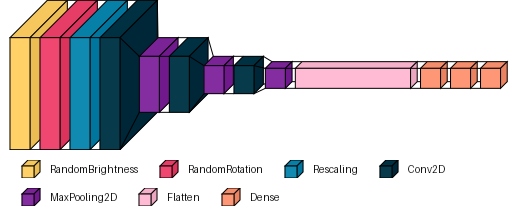

In [ ]:
import visualkeras

visualkeras.layered_view(model.model, legend=True)